In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from sklearn.svm import LinearSVC as csvm
import random
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Adaboost for Classification

In [3]:
# Our usual checkerboard pattern of two rows of clusters of alternating labels
def genStackedCirclesData( d, n, r ):
    tmp1 = gsd.genSphericalData( d, n, [-8, 5], r )
    tmp2 = gsd.genSphericalData( d, n, [0, -5], r )
    tmp3 = gsd.genSphericalData( d, n, [8, 5], r )
    tmp4 = gsd.genSphericalData( d, n, [-8, 5], r/2 )
    tmp5 = gsd.genSphericalData( d, n, [0, -5], r/2 )
    tmp6 = gsd.genSphericalData( d, n, [8, 5], r/2 )
    XPos = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5, tmp6) )
    yPos = np.ones( (XPos.shape[0],) )
    
    tmp1 = gsd.genSphericalData( d, n, [-8, -5], r )
    tmp2 = gsd.genSphericalData( d, n, [0, 5], r )
    tmp3 = gsd.genSphericalData( d, n, [8, -5], r )
    tmp4 = gsd.genSphericalData( d, n, [-8, -5], r/2 )
    tmp5 = gsd.genSphericalData( d, n, [0, 5], r/2 )
    tmp6 = gsd.genSphericalData( d, n, [8, -5], r/2 )
    XNeg = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5, tmp6) )
    yNeg = -np.ones( (XNeg.shape[0],) )
    
    return (XPos, yPos, XNeg, yNeg)

d = 2 
n = 50
r = 3

(XPos, yPos, XNeg, yNeg) = genStackedCirclesData( d, n, r )

Xtrn = np.vstack( (XPos, XNeg) )
ytrn = np.concatenate( (yPos, yNeg) )
randPerm = np.random.permutation( Xtrn.shape[0] )
Xtrn = Xtrn[randPerm,:]
ytrn = ytrn[randPerm]

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


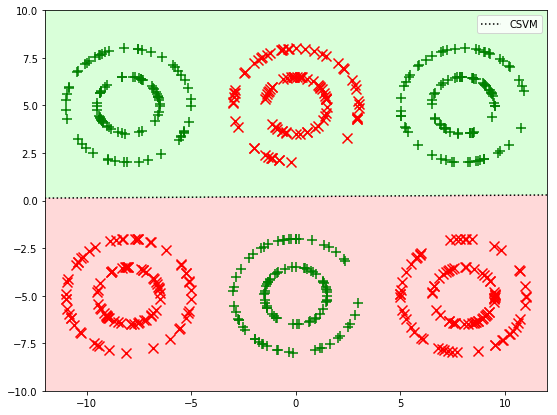

In [4]:
# Fitting a linear classifier to this data yeilds
# mediocre results but still better than random
# performance > 51% classification accuracy or,
# in other words < 49% misclassification error

def linearCSVMClassifier( X ):
    return clf.predict( X )

clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0, fit_intercept = True )
clf.fit( Xtrn, ytrn )

fig = pd.getFigure( 9, 7 )
pd.shade2D( linearCSVMClassifier, fig, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( XPos, fig, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig, color = 'r', marker = 'x' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig, linestyle = ':', xlimL = -12, xlimR = 12, label = "CSVM" )

In [5]:
def ensemblelinearCSVMClassifier( X, plotStumps = True ):
    pred = np.zeros( (X.shape[0],) )
    for i in range( len( ensemble ) ):
        clf = ensemble[i]
        pred += importance[i] * clf.predict( X )
        # Plot the decision boundaries for the first few stumps
        if i < 10 and plotStumps:
            pd.plotLine( clf.coef_.T, clf.intercept_, fig, linestyle = ':', xlimL = -12, xlimR = 12, ylimD = -10, ylimU = 10 )
    return np.sign( pred )

numModels = 20
ensemble = []
importance = []
misclassfnRate = []
trainErr = []

ntr = Xtrn.shape[0]
weights = np.ones( (ntr,) )/ntr

for i in range( numModels ):
    if i == 0:
        clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0, fit_intercept = True )
        clf.fit( Xtrn, ytrn )
    else:
        clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0 * ntr, fit_intercept = True )
        clf.fit( Xtrn, ytrn, sample_weight = weights )
    # score gives (weigted) mean accuracy -- need to convert that into weighted misclassification rate
    eps = 1 - (clf.score( Xtrn, ytrn, sample_weight = weights )/np.sum( weights ))
    # Prevent overflow errors since we are dealing with exponentials here
    if eps < 1/(1 + np.exp( 500 )):
        alpha = -250
    elif eps > 1/(1 + np.exp( -500 )):
        alpha = 250
    else:
        alpha = 0.5 * np.log( (1 - eps)/eps )
    preWeights = weights * np.exp( -alpha * ytrn * clf.predict( Xtrn ) )
    weights = preWeights / np.sum( preWeights )
    ensemble.append( clf )
    misclassfnRate.append( eps )
    importance.append( alpha )
    trainErr.append( (ntr - ensemblelinearCSVMClassifier( Xtrn, plotStumps = False ).dot( ytrn )) / (2 * ntr) )

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37

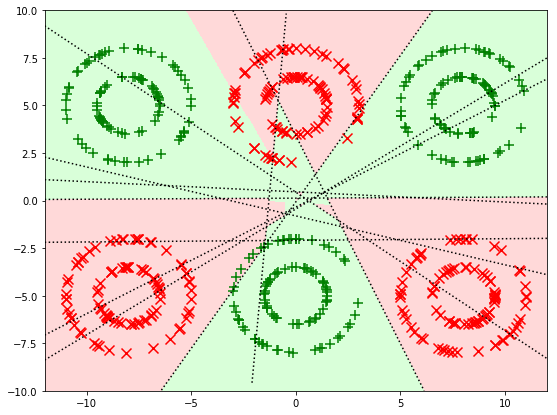

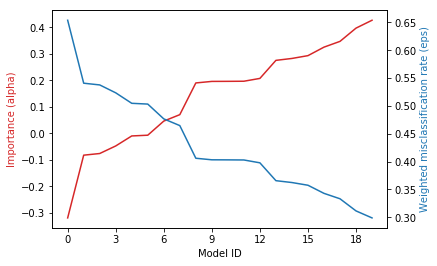

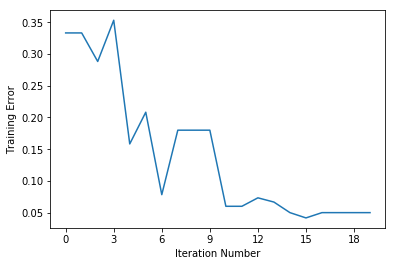

In [6]:
fig2 = pd.getFigure( 9, 7 )
pd.shade2D( ensemblelinearCSVMClassifier, fig2, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'r', marker = 'x' )

plt.figure()
ax = plt.gca()
ax.set_xlabel( "Model ID" )
ax.xaxis.set_major_locator( MaxNLocator( integer = True ) )

ax.set_ylabel( "Importance (alpha)", color = "tab:red" )
ax.plot( np.arange(numModels), np.sort( importance ), color = "tab:red" )

ax2 = ax.twinx()

ax2.plot( np.arange(numModels), np.sort( np.array( misclassfnRate ) )[::-1], color = "tab:blue" )
ax2.set_ylabel( "Weighted misclassification rate (eps)", color = "tab:blue" )

plt.figure()
ax = plt.gca()
ax.set_xlabel( "Iteration Number" )
ax.xaxis.set_major_locator( MaxNLocator( integer = True ) )
ax.set_ylabel( "Training Error" )
ax.plot( np.arange( numModels ), trainErr )

plt.show()

# Gradient Boosted Ensembles for Regression

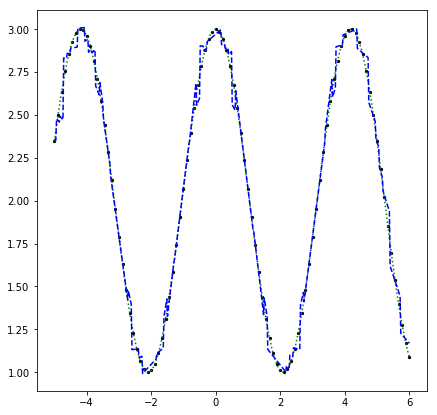

In [7]:
# Our stump is a piecewise linear function: within a certain interval,
# it behaves as a linear function. Outside that interval, it outputs zero
# In higher dimensions, intervals could be replaced by spheres
class Stump:
    def __init__( self, left = -10, right = -9, width = 1, slope = 1, bias = 0 ):
        self.left = left
        self.right = right
        self.width = width
        self.slope = slope
        self.bias = bias
    
    def predict( self, X ):
        y = np.zeros_like( X )
        idx = ( X >= self.left ) & ( X <= self.right )
        y[idx] = X[idx] * self.slope + self.bias
        return y
    
    def train( self, X, y, width ):
        # Consider all training points as potential centres of an interval
        # In higher dimensions, 
        # and all training points could be considered as potential centres
        minErr = np.inf
        self.width = width
        
        for x in X:
            res = np.zeros_like( X )
            idx = ( X >= x - width/2 ) & ( X <= x + width/2 )
            # Solve a least squares problem on points within the interval
            # Add a dummy feature so that we may learn a bias term as well
            XActive = X[idx][:, np.newaxis]
            XActive = np.hstack( (XActive, np.ones_like( XActive )) )
            yActive = y[idx]
            w = np.linalg.inv( XActive.T.dot( XActive ) + 0.1 * np.identity( 2 ) ).dot( XActive.T.dot( yActive ) )
            res[idx] = y[idx] - X[idx] * w[0] - w[1]
            res[~idx] = y[~idx] # Outside the interval we simply predict zero
            err = lin.norm( res, 2 )
            if err < minErr:
                minErr = err
                self.left = x - width/2
                self.right = x + width/2
                self.slope = w[0]
                self.bias = w[1]

# Our GB Ensemble uses stumps of fixed width to simplify the code
# One can search for best width as well -- more expensive training
class GBEnsemble:
    def __init__( self, numModels = 1, width = 1 ):
        self.numModels = numModels
        self.width = width
        self.ensemble = []
        self.bias = 0
    
    def train( self, X, y ):
        self.ensemble = []
        # The constant that minimizes least squares loss on train data is simply
        # the average response. Apply first order optimality to see this
        self.bias = np.mean( y )
        r = y - self.bias
        # We are not doing a weighted combination of stumps like GB does. For this
        # reason, no line search required. This is because this is a simple least
        # squares regression problem where merely fitting residuals is sufficient.
        # For complex problems, a line search over alpha_t would indeed be required
        for i in range( self.numModels ):
            stump = Stump()
            stump.train( X, r, self.width )
            r = r - stump.predict( X )
            self.ensemble.append( stump )
    
    def predict( self, X ):
        pred = np.zeros_like( X )
        for i in range( self.numModels ):
            pred += self.ensemble[i].predict( X )
        return pred + self.bias

def getGoldLabel( X ):
    return np.cos( freq * X ) + shift

def getEnsemblePred( X ):
    return GBE.predict( X )
    
n = 100
freq = 1.5
xlimL = -5
xlimR = 6
shift = 2
X = np.linspace( xlimL, xlimR, n, endpoint = True )
y = np.cos( freq * X ) + shift

# Smaller widths tend to overfit to the training data if lots of
# them are used. In order to train with stumps of smaller width
# without risk of overfitting, more training data should be used
GBE = GBEnsemble( numModels = 100, width = 1.0 )
GBE.train( X, y )

fig3 = pd.getFigure()
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig3, color = 'k', marker = 'o', size = 5 )
pd.plotCurve( getGoldLabel, fig3, mode = "batch", color = 'g', linestyle = ":", xlimL = xlimL, xlimR = xlimR )
pd.plotCurve( getEnsemblePred, fig3, mode = "batch", color = 'b', linestyle = "--", xlimL = xlimL, xlimR = xlimR )